In [4]:
# imports
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.optimize import curve_fit
import corner
import emcee
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import timeit

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%timeit
from IPython.display import Latex

In [5]:
# load list of pulsar names
pulsar_names = np.loadtxt('classic_psrs.txt', dtype=np.unicode_)
n_psrs = len(pulsar_names)

In [6]:
# save Tspan, calc freqs
Tspan = 952746385.6296968 # s
inv_T = 1/Tspan
freq = np.arange(1,6)*inv_T

In [4]:
# associate each pulsar to correct output dir
outdirs = dict(zip(pulsar_names, ['results/psr_'+str(i) for i in range(n_psrs)]))

In [5]:
# load list of parameter labels to dict corresponding to each psr. Also adds in metadata par labels
metadata_pars = ['log-likelihood', 'unweighted log-posterior', 'MCMC acceptance rate', 'interchain transitions acceptance rate']
pars = {psr : np.append(np.loadtxt(outdirs[psr] + '/pars.txt', dtype=np.unicode_),metadata_pars) for psr in pulsar_names}

In [6]:
# plot violin plots of gw_log10_rho comps for each psr
rho_labels = ['gw_log10_rho_0', 'gw_log10_rho_1', 'gw_log10_rho_2', 'gw_log10_rho_3', 'gw_log10_rho_4',]

In [7]:
# load chain data to dict for each psr. Calc burn-in cut-off for each psr
chains = {psr : pd.read_csv(outdirs[psr] + '/chain_1.txt', sep='\t', dtype=float, header=None, names=pars[psr], error_bad_lines=False) for psr in pulsar_names}
burns = {psr : int(0.25*chains[psr].shape[0]) for psr in pulsar_names}

#### powerlaw function

In [8]:
# function to calculate powerlaw at each frequency
def powerlaw(freqs, log10_A, gamma):
    fyr = 1.0 / 365.25 / 86400.0
    log10_A = log10_A
    gamma = gamma
    plaw = 10**(2.0 * log10_A) * (freqs / fyr)**(-gamma) / 12.0 / np.pi**2.0
    plaw /= fyr**3.0 # psd usually given in units = (year)^3; this corrects that
    plaw *= freqs[0] # this multiplies by Tspan, which is the zeroth frequnecy here
    return 0.5 * np.log10(plaw)

###### log prior

In [9]:
def log_prior(params):
    
    gamma  = params[0]
    log10A = params[1]
    
    if 0. < gamma < 7. and -16. < log10A < -12.:
        return 0.0
    else:
        return -np.inf

###### log likely

In [10]:
# function to calculate powerlaw at each frequency
fyr = 1.0 / 365.25 / 86400.0
freq_fyr = freq/fyr

# psd usually given in units = (year)^3; this corrects that
# this multiplies by Tspan, which is the zeroth frequnecy here
Tspan_fyr3 = freq[0]/fyr**3.0 / 12.0 / np.pi**2.0
"""
def log_likely(params):
    
    gamma  = params[0]
    log10A = params[1]
    
    plaw = 10**(2.0 * log10A) * freq_fyr**(-gamma)
    #plaw /= fyr**3.0 # psd usually given in units = (year)^3; this corrects that
    #plaw *= freq[0] # this multiplies by Tspan, which is the zeroth frequnecy here
    plaw *= Tspan_fyr3
    logrho = 0.5 * np.log10(plaw)
    
    # calculate log_prob over freq
    log_prob = np.sum([[rvhist_psr_freq[psr][rho_labels[jj]].logpdf(logrho[jj]) for jj in range(no_freqs)] for psr in pulsar_list])
    #log_prob_sum = np.sum(log_prob)
    
    return log_prob
"""

'\ndef log_likely(params):\n    \n    gamma  = params[0]\n    log10A = params[1]\n    \n    plaw = 10**(2.0 * log10A) * freq_fyr**(-gamma)\n    #plaw /= fyr**3.0 # psd usually given in units = (year)^3; this corrects that\n    #plaw *= freq[0] # this multiplies by Tspan, which is the zeroth frequnecy here\n    plaw *= Tspan_fyr3\n    logrho = 0.5 * np.log10(plaw)\n    \n    # calculate log_prob over freq\n    log_prob = np.sum([[rvhist_psr_freq[psr][rho_labels[jj]].logpdf(logrho[jj]) for jj in range(no_freqs)] for psr in pulsar_list])\n    #log_prob_sum = np.sum(log_prob)\n    \n    return log_prob\n'

# Sampler

###### ptmcmc over pulsars and freqs takes ~40mins for N=1e5
###### compared to 1min by summing over pulsars

In [11]:
# common set of bins across all psrs
rho_bins = np.linspace(-9, -4, num=50)

In [12]:
# multiply histograms of each psr for each rho. Save to dict corresponding to each rho
epsilon = 1e-20
histograms = {psr : {rho: np.histogram(chains[psr][rho][burns[psr]:], rho_bins, density=True)[0]+epsilon for rho in rho_labels} for psr in pulsar_names}

In [13]:
# generate distribution from each rho histogram
bin_mid = (rho_bins[1:] + rho_bins[:-1]) / 2.0
rvhist_psr_freq = {psr: {rho : scipy.stats.rv_histogram([histograms[psr][rho], rho_bins]) for rho in rho_labels} for psr in pulsar_names}

In [14]:
ndim = 2
p0 = np.random.rand(ndim)
p0[0] *= 7.
p0[1] = -16.+p0[1]*3

cov = np.identity(ndim)*0.2

In [15]:
no_freqs = len(freq)

In [16]:
pulsar_list = pulsar_names

In [17]:
#sampler = ptmcmc(ndim, log_likely, log_prior, cov, outDir='nb_chains/sing_psr_freq_chain/', resume=True)

In [18]:
# sampler for N steps
N = 100000
#sampler.sample(p0, N)

In [19]:
pars_mcmc = ['gamma', 'gw_log10_A', *metadata_pars]
samps = pd.read_csv('nb_chains/sing_psr_freq_chain/chain_1.txt', delim_whitespace=True, header=None, names=pars_mcmc)

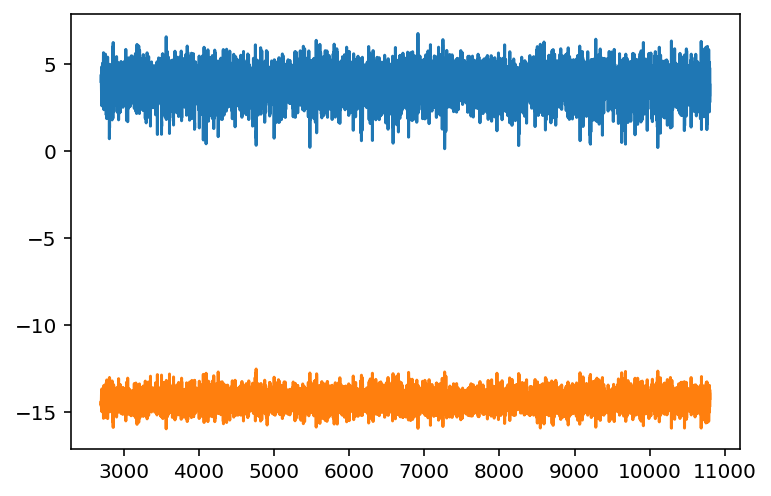

In [166]:
burn_samps = int(0.25*samps.shape[0])

plt.plot(samps[burn_samps:][pars_mcmc[:2]])

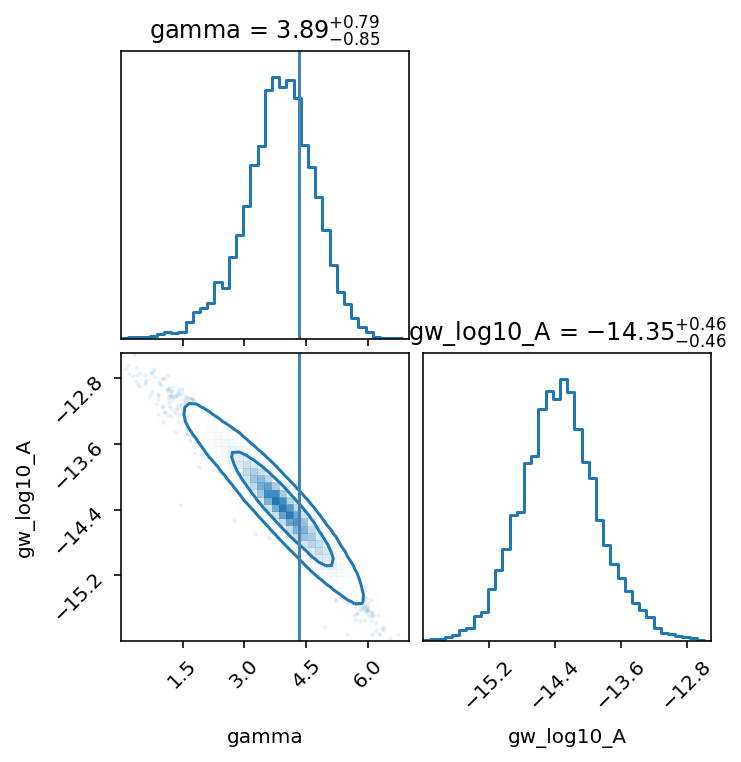

In [167]:
truths = [13/3,None]
corner.corner(samps[pars_mcmc[:2]][burn_samps:], bins=40, range=[(0,7),(-16,-12.5)], levels=[0.68,0.95], smooth=True, smooth1d=False, labels=pars_mcmc[:2], show_titles=True, truths=truths, color='C0');

In [46]:
# function to calculate powerlaw at each frequency
fyr = 1.0 / 365.25 / 86400.0
freq_fyr = freq/fyr

Tspan = 952746385.6296968 # s
inv_T = 1/Tspan

no_freq = len(freq)
no_bins = len(rho_bins)-1

# psd usually given in units = (year)^3; this corrects that
# this multiplies by Tspan, which is the zeroth frequnecy here
Tspan_fyr3 = inv_T/fyr**3.0 / 12.0 / np.pi**2.0

def log_likely(params):
    
    gamma  = params[0]
    log10A = params[1]
    
    plaw = 10**(2.0 * log10A) * freq_fyr**(-gamma)
    #plaw /= fyr**3.0 # psd usually given in units = (year)^3; this corrects that
    #plaw *= freq[0] # this multiplies by Tspan, which is the zeroth frequnecy here
    plaw *= Tspan_fyr3
    logrho = 0.5 * np.log10(plaw)
    
    if all(logrho > -9) and all(logrho < -4):
        
        # calculate log_prob over freq
        idx = np.digitize(logrho, rho_bins)
        idx -= 1 # correct OBO error
        
        pdf = np.array([[histograms[psr][rho_labels[ii]][idx[ii]] for ii in range(no_freq)] for psr in pulsar_names])
        logpdf = np.log(pdf)
    
        logpdf_sum = np.sum(logpdf)
        
    else:
        logpdf_sum = -np.inf
    
    return logpdf_sum

In [22]:
log_likely_dig([4, np.log10(5e-15)])

-359.28197974462336

In [29]:
sampler = ptmcmc(ndim, log_likely, log_prior, cov, outDir='nb_chains/sing_psr_freq_chain_dig/', resume=True)

In [31]:
# sampler for N steps
N = 100000
sampler.sample(p0, N)

Finished 10.00 percent in 4.531533 s Acceptance rate = 0.58739Adding DE jump with weight 20
Finished 99.00 percent in 44.629379 s Acceptance rate = 0.499434
Run Complete


In [32]:
pars_mcmc = ['gamma', 'gw_log10_A', *metadata_pars]
samps = pd.read_csv('nb_chains/sing_psr_freq_chain_dig/chain_1.txt', delim_whitespace=True, header=None, names=pars_mcmc)

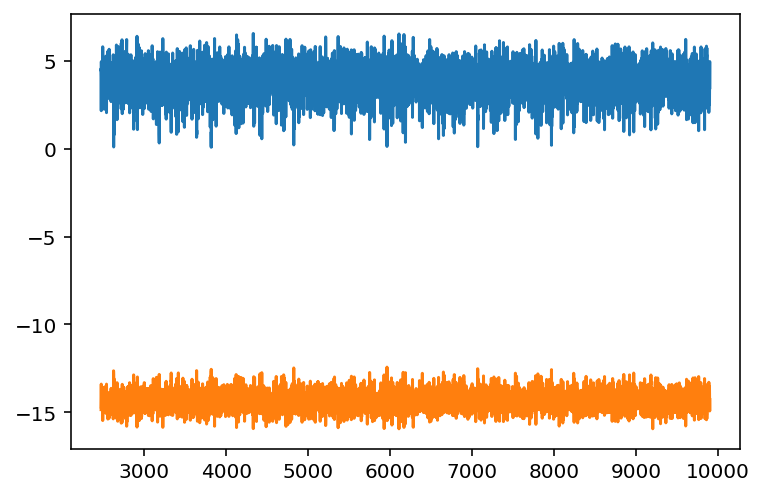

In [33]:
burn_samps = int(0.25*samps.shape[0])

plt.plot(samps[burn_samps:][pars_mcmc[:2]])

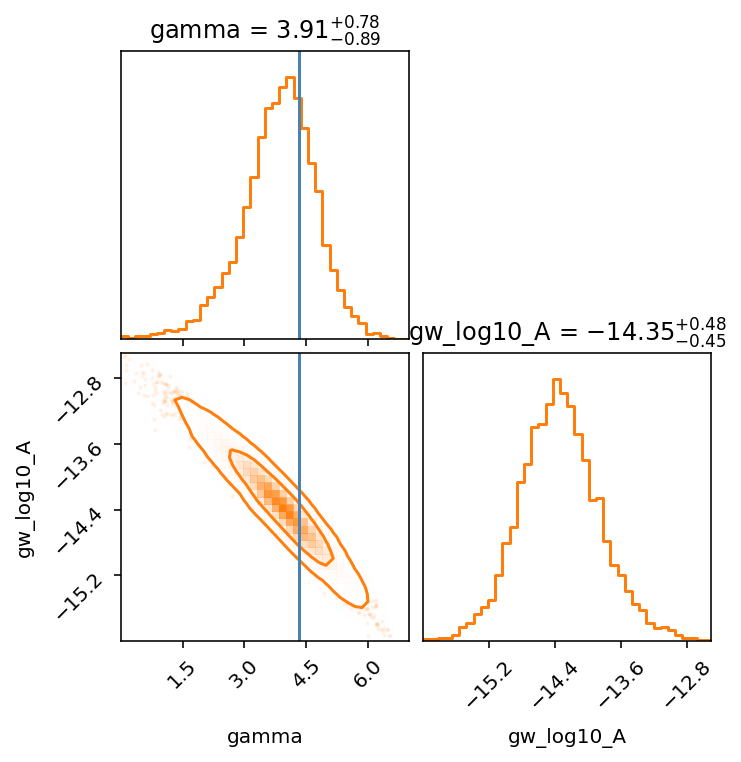

In [34]:
truths = [13/3,None]
corner.corner(samps[pars_mcmc[:2]][burn_samps:], bins=40, range=[(0,7),(-16,-12.5)], levels=[0.68,0.95], smooth=True, smooth1d=False, labels=pars_mcmc[:2], show_titles=True, truths=truths, color='C1');

In [28]:
class psrs:
    
    # move psd to another function
    def __init__(self, Tspan, no_freq, pulsar_names, chain_outdir, psd='powerlaw'):
        self.Tspan = Tspan
        self.no_freq = no_freq
        self.freqs = np.arange(1, no_freq+1)*(1/Tspan)
        
        self.pulsar_names = pulsar_names
        self.pulsar_list  = pulsar_names
        self.n_psrs = len(pulsar_names)
        
        self.outdirs = dict(zip(pulsar_names, [chain_outdir + '/psr_'+str(i) for i in range(self.n_psrs)]))
        
        metadata_pars = ['log-likelihood', 'unweighted log-posterior', 'MCMC acceptance rate', 'interchain transitions acceptance rate']
        self.pars = {psr : np.append(np.loadtxt(self.outdirs[psr] + '/pars.txt', dtype=np.unicode_),metadata_pars) for psr in pulsar_names}
        
        self.rho_labels = ['gw_log10_rho_'+str(i) for i in range(self.no_freq)]
        
        # load chain data to dict for each psr. Calc burn-in cut-off for each psr
        print('loading chains...')
        self.chains = {psr : pd.read_csv(self.outdirs[psr] + '/chain_1.txt', sep='\t', dtype=float, header=None, names=self.pars[psr], error_bad_lines=False) for psr in pulsar_names}
        
        self.burns  = {psr : int(0.25*self.chains[psr].shape[0]) for psr in pulsar_names}
        
        return
        
    def histograms(self, no_rho_bins=50):
        # common set of bins across all psrs
        rho_bins = np.linspace(-9, -4, num=no_rho_bins)
        self.rho_bins = rho_bins
        
        # multiply histograms of each psr for each rho. Save to dict corresponding to each rho
        epsilon = 1e-20
        self.hists = {psr : {rho: np.histogram(self.chains[psr][rho][self.burns[psr]:], rho_bins, density=True)[0]+epsilon for rho in self.rho_labels} for psr in self.pulsar_names}
        
        return
    
    def selected_pulsars(self, pulsar_list):
        self.pulsar_list = pulsar_list
        
        return
        
    def powerlaw(self, params):
        
        gamma  = params[0]
        log10_A = params[1]
        
        fyr = 1.0 / 365.25 / 86400.0
        
        plaw = 10**(2.0 * log10_A) * (self.freqs / fyr)**(-gamma) / 12.0 / np.pi**2.0
        plaw /= fyr**3.0 # psd usually given in units = (year)^3; this corrects that
        plaw *= self.freqs[0] # this multiplies by Tspan, which is the zeroth frequnecy here
        return 0.5 * np.log10(plaw)
        
    def broken_powerlaw(self, params, delta, log10_fb, kappa=0.1):
        """
        Generic broken powerlaw spectrum.
        :param f: sampling frequencies
        :param A: characteristic strain amplitude [set for gamma at f=1/yr]
        :param gamma: negative slope of PSD for f > f_break [set for comparison
            at f=1/yr (default 13/3)]
        :param delta: slope for frequencies < f_break
        :param log10_fb: log10 transition frequency at which slope switches from
            gamma to delta
        :param kappa: smoothness of transition (Default = 0.1)
        """

        gamma  = params[0]
        log10_A = params[1]
        
        fyr = 1.0 / 365.25 / 86400.0

        f = self.freqs

        df = 1/self.Tspan
        hcf = (
            10 ** log10_A
            * (f / fyr) ** ((3 - gamma) / 2)
            * (1 + (f / 10 ** log10_fb) ** (1 / kappa)) ** (kappa * (gamma - delta) / 2)
        )

        return np.log10(hcf ** 2 / 12 / np.pi ** 2 / f ** 3 * df) # is it correct to log10?
    
    def common_process_setup(self, cp_model='powerlaw', **kwargs):
        
        if cp_model == 'powerlaw':
            self.cp_model = 'powerlaw'
        
        if cp_model == 'broken_powerlaw':
            self.cp_model = 'broken_powerlaw'
            self.delta = kwargs.get('delta', 0)
            self.log10_fb = kwargs.get('log10_fb')
            self.kappa = kwargs.get('kappa', 0.1)
            
        return
    
    def log_likelihood(self, params):
        
        if self.cp_model == 'powerlaw':
            logrho = self.powerlaw(params)
            
        elif self.cp_model == 'broken_powerlaw':
            logrho = self.broken_powerlaw(params, self.delta, self.log10_fb) #add kappa
        
        if all(logrho > -9) and all(logrho < -4):
        
            # calculate log_prob over freq
            idx = np.digitize(logrho, self.rho_bins)
            idx -= 1 # correct OBO error

            pdf = np.array([[self.hists[psr][self.rho_labels[ii]][idx[ii]] for ii in range(self.no_freq)] for psr in self.pulsar_list])
            logpdf = np.log(pdf)

            logpdf_sum = np.sum(logpdf)

        else:
            logpdf_sum = -np.inf

        return logpdf_sum

    def log_prior(self, params):
        gamma  = params[0]
        log10A = params[1]

        if 0. < gamma < 7. and -16. < log10A < -12.:
            return 0.0
        else:
            return -np.inf
        

In [29]:
# load list of pulsar names
pulsar_names = np.loadtxt('classic_psrs.txt', dtype=np.unicode_)
n_psrs = len(pulsar_names)
Tspan = 952746385.6296968 # s

In [30]:
psr = psrs(Tspan, 5, pulsar_names, 'results')

loading chains...


In [10]:
psr.histograms()

In [11]:
psr.common_process_setup()

In [12]:
params = np.array([13/3, np.log10(2.2e-15)])
gamma, log10A = params
ndim = 2
cov = np.identity(ndim)*0.2

In [13]:
sampler = ptmcmc(ndim, psr.log_likelihood, psr.log_prior, cov, outDir='nb_chains/sing_psr_freq_chain_class/', resume=False)

In [14]:
# sampler for N steps
N = 100000
sampler.sample(params, N)

Finished 10.00 percent in 4.460399 s Acceptance rate = 0.48557Adding DE jump with weight 20
Finished 99.00 percent in 45.673945 s Acceptance rate = 0.495535
Run Complete


In [15]:
metadata_pars = ['log-likelihood', 'unweighted log-posterior', 'MCMC acceptance rate', 'interchain transitions acceptance rate']
pars_mcmc = ['gamma', 'gw_log10_A', *metadata_pars]
samps = pd.read_csv('nb_chains/sing_psr_freq_chain_class/chain_1.txt', delim_whitespace=True, header=None, names=pars_mcmc)

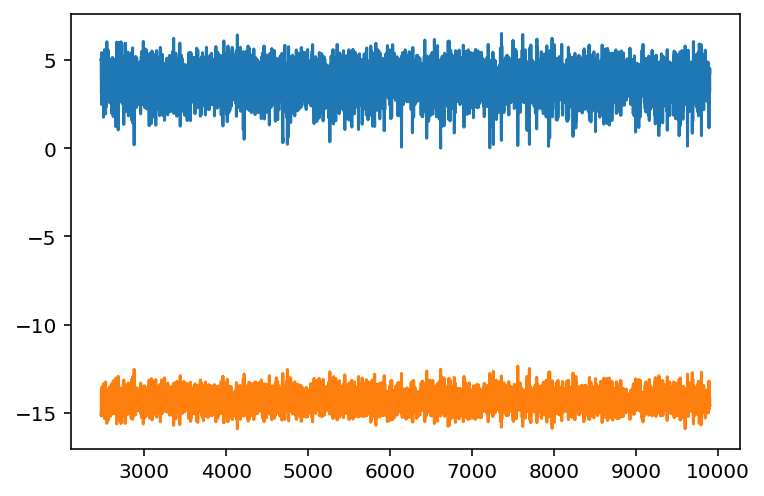

In [16]:
burn_samps = int(0.25*samps.shape[0])

plt.plot(samps[burn_samps:][pars_mcmc[:2]])

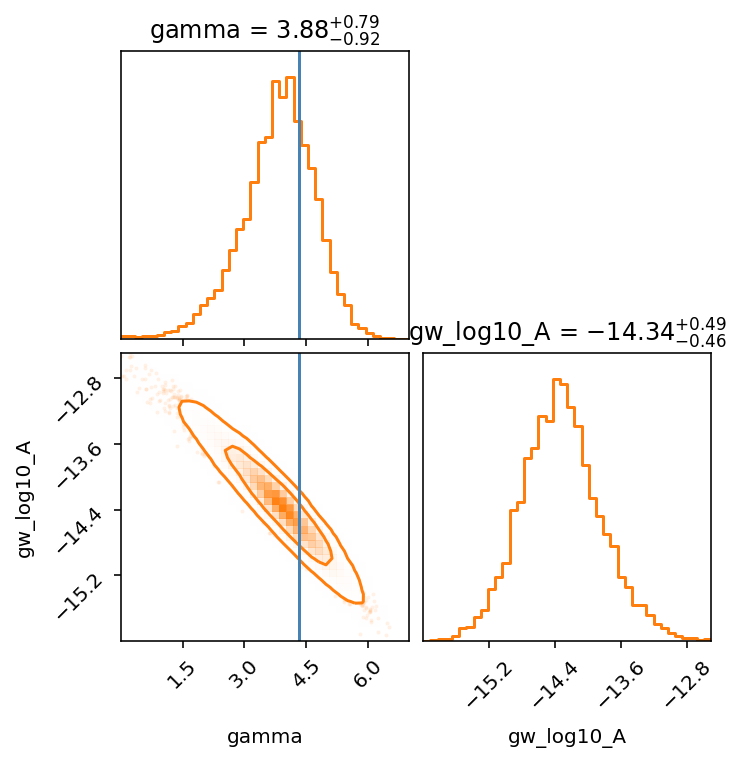

In [17]:
truths = [13/3,None]
corner.corner(samps[pars_mcmc[:2]][burn_samps:], bins=40, range=[(0,7),(-16,-12.5)], levels=[0.68,0.95], smooth=True, smooth1d=False, labels=pars_mcmc[:2], show_titles=True, truths=truths, color='C1');

In [18]:
psr.common_process_setup(cp_model='broken_powerlaw', delta=0, log10_fb=psr.freqs[2])

In [19]:
params = np.array([13/3, np.log10(2.2e-15)])
gamma, log10A = params
ndim = 2
cov = np.identity(ndim)*0.2

In [20]:
sampler = ptmcmc(ndim, psr.log_likelihood, psr.log_prior, cov, outDir='nb_chains/sing_psr_freq_chain_class2/', resume=False)

In [21]:
# sampler for N steps
N = 100000
sampler.sample(params, N)

Finished 1.00 percent in 0.151680 s Acceptance rate = 0

/Users/lambwg/apps/miniconda3/envs/pta_software/lib/python3.8/site-packages/PTMCMCSampler/PTMCMCSampler.py:494: RuntimeWarning: invalid value encountered in double_scalars
  diff = newlnprob - lnprob0 + qxy


Finished 10.00 percent in 1.572113 s Acceptance rate = 0Adding DE jump with weight 20
Finished 99.00 percent in 15.727422 s Acceptance rate = 0
Run Complete


In [22]:
metadata_pars = ['log-likelihood', 'unweighted log-posterior', 'MCMC acceptance rate', 'interchain transitions acceptance rate']
pars_mcmc = ['gamma', 'gw_log10_A', *metadata_pars]
samps = pd.read_csv('nb_chains/sing_psr_freq_chain_class2/chain_1.txt', delim_whitespace=True, header=None, names=pars_mcmc)

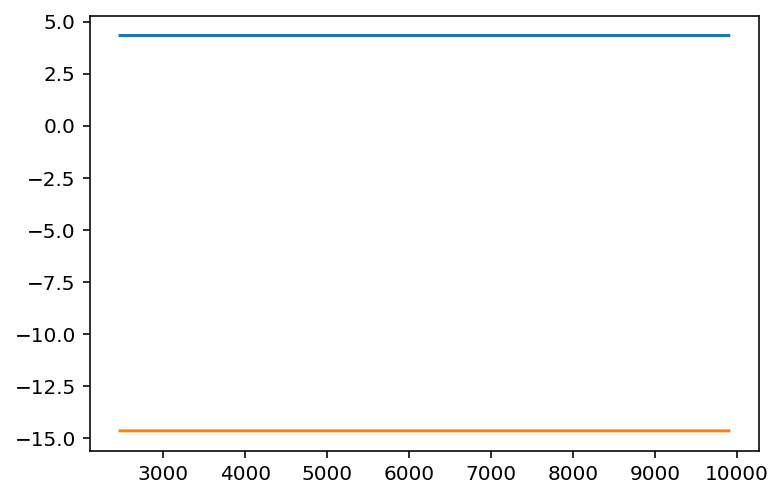

In [23]:
burn_samps = int(0.25*samps.shape[0])

plt.plot(samps[burn_samps:][pars_mcmc[:2]])

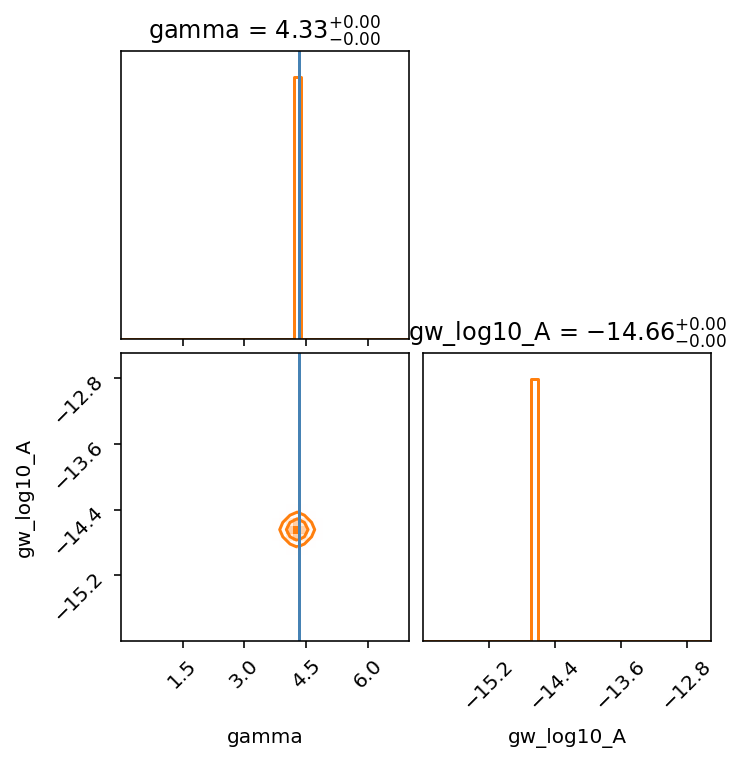

In [24]:
truths = [13/3,None]
corner.corner(samps[pars_mcmc[:2]][burn_samps:], bins=40, range=[(0,7),(-16,-12.5)], levels=[0.68,0.95], smooth=True, smooth1d=False, labels=pars_mcmc[:2], show_titles=True, truths=truths, color='C1');

In [42]:
0.5*psr.broken_powerlaw(params, delta=3, log10_fb=psr.freqs[2])

array([-5.72875828, -6.38098993, -6.762521  , -7.03322159, -7.24319329])

In [37]:
"""
Next steps

- make a model class, access logprior, loglikely as model.logprior etc.

TO-DO for Busy Week:
> do this on prelim 15yr dataset - prelim1
> run single pulsar analyses on prelim1 -> find Tspan of full PTA, 30 freq intrinsic red noise, free spectrum CP, CP10 freq
> then can do spectral characterisation
> add command to analyse certain pulsars
> option - vary white noise
> option2 - same analyses, but full PTA Tspan, 30 freq int RN free spectrum, with and w/o varying WN (--red_psd spectrum)
"""

'\nNext steps\n\n- make a model class, access logprior, loglikely as model.logprior etc.\n'